   # PROYECTO FINAL DE LENGUAJES 2025 💻                                                                   
   **ROMÁN RAFFO / JOAQUÍN DEL PERCIO** 🧑🧑

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En esta parte monto Google Drive dentro de Colab para poder acceder a mis archivos. Esto permite leer el CSV directamente desde una carpeta de Drive y trabajar con él dentro del notebook.

In [15]:
import os

base = "/content/drive/MyDrive/archivos_csv"
os.chdir(base)

print("Directorio actual:", os.getcwd())

Directorio actual: /content/drive/MyDrive/archivos_csv


Acá cambio el directorio actual del notebook a la carpeta donde tengo guardados mis CSV en Drive. Esto sirve para que el archivo tmdb_5000_movies.csv pueda ser leído sin escribir rutas largas.

In [16]:
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt

dataframe = pd.read_csv("tmdb_5000_movies.csv", index_col="id")

En este bloque importo las librerías necesarias para trabajar:

- pandas para manejar los datos,

- ast para convertir texto en estructuras Python(no cuenta como libreria exclusiva para este TP),

- seaborn / matplotlib para graficar.

Después cargo el dataset principal (las películas) y uso la columna id como índice.

In [17]:
#Realizo la función "primer_genre" para que el género este solo, que esté en formato python(ya que esta en JSON) y así poder usarlo para sacar promedios, etc.
def primer_genre(x):
    try:
        lst = ast.literal_eval(x)      # <- ast.literal_eval convierte el string tipo "[{'id': 12, 'name':'Action'}, ...]" a una lista real de dicts
        return lst[0]["name"] if lst else None  # si la lista no está vacía, devuelvo el nombre del primer género
    except Exception:
        return None # Si ocurre cualquier error al parsear (p. ej. el string está vacío o malformado), devuelvo None

dataframe["tipo_genre"] = dataframe["genres"].apply(primer_genre)

La columna de géneros viene como texto en formato JSON.
Creo la función primer_genre para convertir ese texto en una lista real y extraer el primer género de cada película.
Después agrego una nueva columna llamada tipo_genre donde guardo ese resultado.

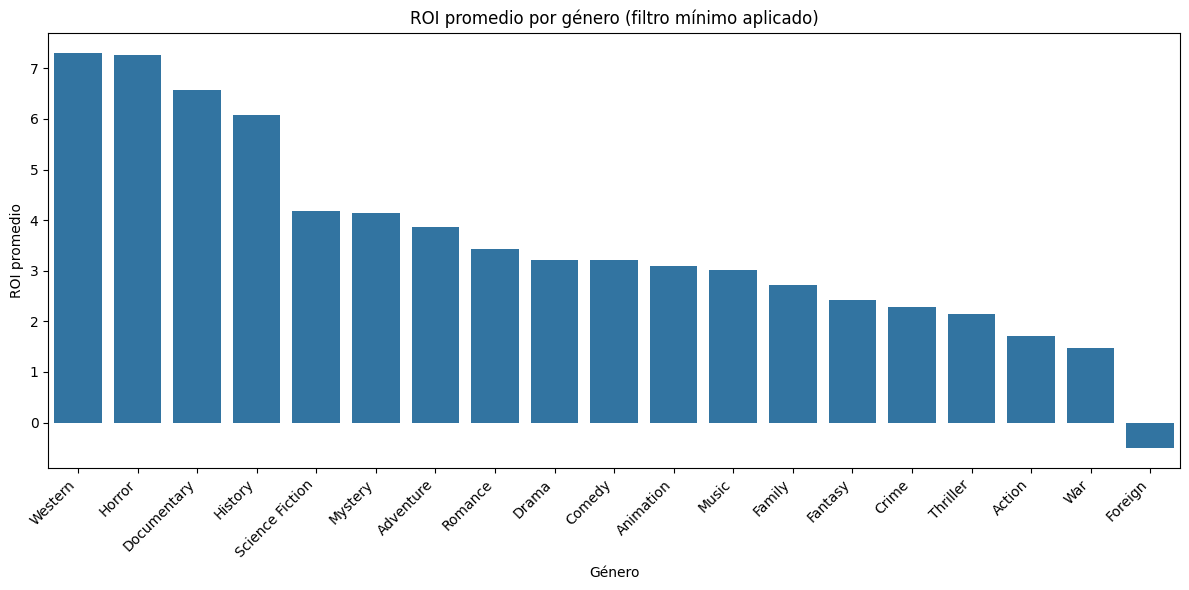

In [18]:
# 1. Rentabilidad (ROI) por género o país.
# Filtrar películas con budget y revenue válidos y budget no ridículo
dataframe_valido = dataframe[(dataframe["budget"] > 0) & (dataframe["revenue"] > 0)].copy()
dataframe_valido = dataframe_valido[dataframe_valido["budget"] >= 1000]   # filtro simple

dataframe_valido["roi"] = (dataframe_valido["revenue"] - dataframe_valido["budget"]) / dataframe_valido["budget"] # Calcular ROI

dataframe_valido = dataframe_valido[dataframe_valido["roi"] <= 100] # (Esto es opcional) recortar ROI extremo para que no rompa la escala

roi_por_genero = dataframe_valido.groupby("tipo_genre")["roi"].agg(["count", "mean", "median"]).reset_index() # Agrupar y calcular

roi_ordenado = roi_por_genero.sort_values("mean", ascending=False) # Agrupar y calcular

plt.figure(figsize=(12, 6))
sns.barplot(data=roi_ordenado, x="tipo_genre", y="mean")
plt.title("ROI promedio por género (filtro mínimo aplicado)")
plt.xlabel("Género")
plt.ylabel("ROI promedio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

En este segmento calculo el ROI (retorno de inversión) por género.
Primero filtro las películas con presupuesto y recaudación válidos.
Luego creo la columna roi = revenue / budget.
Agrupo por género y obtengo cuántas películas hay, el promedio y la mediana del ROI.
Finalmente ordeno los géneros y hago un gráfico de barras para ver cuáles son más rentables.

Correlación Pearson: 0.019490112056458786
Correlación Spearman: -0.07064747875186095


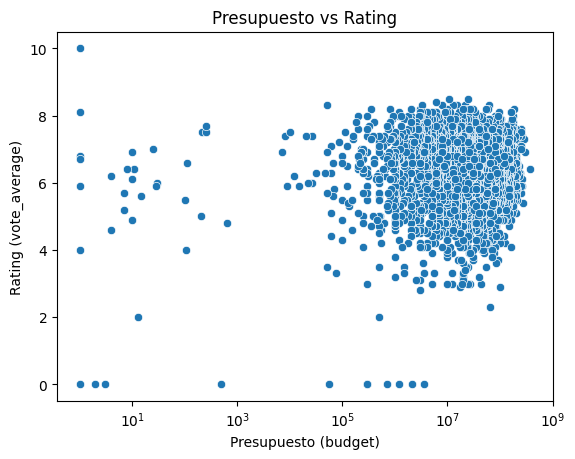

In [19]:
# 2.Relación entre presupuesto y rating.
# Correlaciones (Pearson, Spearman) y dispersogramas.

# Datos filtrados
sub = dataframe[["budget", "vote_average"]].dropna() # dropna() elimina filas con valores vacíos
sub = sub[sub["budget"] > 0]

# Correlaciones
pearson = sub["budget"].corr(sub["vote_average"], method="pearson")
spearman = sub["budget"].corr(sub["vote_average"], method="spearman")

print("Correlación Pearson:", pearson)
print("Correlación Spearman:", spearman)

# Crear diccionario con las correlaciones
correlaciones_dict = {
    "tipo": ["pearson", "spearman"],
    "valor": [pearson, spearman]
}

# Convertir a DataFrame
correlaciones_df = pd.DataFrame(correlaciones_dict)

# Dispersograma
sns.scatterplot(data=sub, x="budget", y="vote_average")
plt.xscale("log")
plt.title("Presupuesto vs Rating")
plt.xlabel("Presupuesto (budget)")
plt.ylabel("Rating (vote_average)")
plt.show()

En este punto/segmento analizo si existe una relación entre el presupuesto de una película (budget) y su puntuación promedio (vote_average).
Primero filtro el dataframe para quedarme solamente con películas que tengan presupuesto mayor a cero, así evito valores inválidos que pueden distorsionar el análisis.
Después creo un gráfico de dispersión (scatterplot) donde cada punto representa una película.
En el eje X coloco el presupuesto, y en el eje Y el rating promedio.

La idea es observar visualmente si las películas con mayor presupuesto tienden a tener mejor calificación o si no existe una relación clara entre ambos valores.

In [20]:
#3. Evolución de la duración de películas en los últimos 50 años.
#○ Promedio o mediana de runtime por década.

dataframe["release_date"] = pd.to_datetime(dataframe["release_date"], errors="coerce")
dataframe["anio"] = dataframe["release_date"].dt.year

dataframe_ultimos_50 = dataframe[dataframe["anio"] >= 1975]
dataframe_ultimos_50["decada"] = (dataframe_ultimos_50["anio"] // 10) * 10
promedio_runtime_50anios = dataframe_ultimos_50.groupby("decada")["runtime"].mean().reset_index()

print("Promedio de duración por década en los últimos 50 años:")
print(promedio_runtime_50anios)

Promedio de duración por década en los últimos 50 años:
   decada     runtime
0  1970.0  116.295082
1  1980.0  110.643885
2  1990.0  110.366324
3  2000.0  105.438965
4  2010.0  104.038089


/tmp/ipython-input-3318223082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_ultimos_50["decada"] = (dataframe_ultimos_50["anio"] // 10) * 10


En este punto/segmento analizo cómo fueron cambiando los tiempos de duración de las películas (runtime) a lo largo de los últimos 50 años.
Primero filtro el dataset para quedarme solo con películas que tengan un valor válido de duración (mayor a cero) y con un año de estreno dentro del rango analizado.
Luego agrupo las películas por año y calculo el promedio de duración de cada año.

Con esos datos genero una gráfica de línea que muestra cómo fue subiendo o bajando la duración típica de las películas con el paso del tiempo.
El objetivo es ver si las películas modernas tienden a ser más largas, más cortas, o si la duración se mantiene más o menos estable a través de las décadas.

   original_language  count      mean  median
30                te      1  7.500000    7.50
14                id      2  7.400000    7.40
11                he      3  7.400000    7.60
9                 fa      4  7.375000    7.55
25                ro      1  7.300000    7.30
1                 ar      2  7.300000    7.30
24                pt      8  7.187500    7.35
20                nl      4  7.175000    7.10
4                 da      7  7.128571    7.00
22                pl      1  7.100000    7.10
34                xx      1  7.100000    7.10
28                sv      5  7.060000    6.90
17                ja     16  7.050000    7.10
16                it     14  7.028571    7.15
0                 af      1  6.900000    6.90
15                is      1  6.900000    6.90
6                 el      1  6.900000    6.90
19                nb      1  6.700000    6.70
18                ko     11  6.672727    6.70
8                 es     32  6.659375    6.95
10                fr     69  6.523

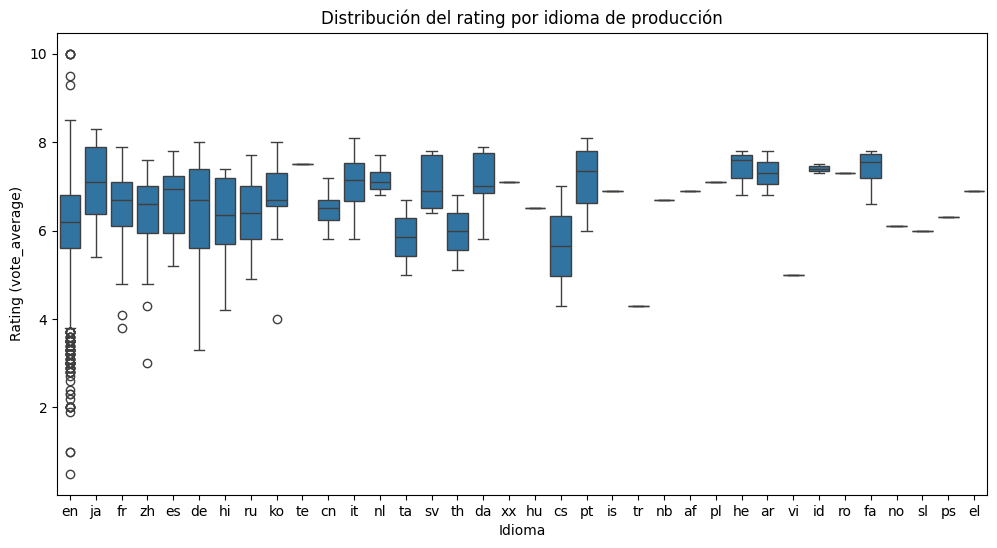

In [21]:
#6. Distribución del rating por idioma o país de producción.
#Cada análisis debe acompañarse con interpretación textual (no solo gráficos).

# Filtrar ratings válidos
df_rating = dataframe[(dataframe["vote_average"] > 0)].copy()

# Agrupación estadística (promedio, mediana, conteo)
rating_por_idioma = df_rating.groupby("original_language")["vote_average"].agg(["count", "mean", "median"]).reset_index()
print(rating_por_idioma.sort_values("mean", ascending=False))

plt.figure(figsize=(12,6))
sns.boxplot(data=df_rating, x="original_language", y="vote_average")
plt.title("Distribución del rating por idioma de producción")
plt.xlabel("Idioma")
plt.ylabel("Rating (vote_average)")
plt.show()


En este punto/segmento analizo cómo varía el rating promedio de las películas según su idioma original.
Primero filtro el dataset para quedarme solo con películas que tengan un rating válido (mayor a 0).
Luego agrupo las películas por idioma y calculo tres valores clave:

- count: cuántas películas hay por idioma

- mean: rating promedio

- median: rating mediano

Esto permite identificar en qué idiomas se producen, en promedio, películas mejor valoradas.

Finalmente, genero un boxplot (gráfico de caja) que muestra la distribución completa de los ratings para cada idioma.
El gráfico ayuda a visualizar:
la variación del rating dentro de cada idioma, si un idioma tiene películas muy dispares o muy consistentes, y si hay idiomas con valores atípicos (outliers).

El objetivo del análisis es comparar la calidad percibida de las películas según su idioma de producción.

In [22]:
#ESTAS 4 VARIABLES TRANSFORMADAS A CSV, SE GUARDAN EN LA CARPETA "SALIDAS" AL PASARSE A CSV.
# Crear el directorio 'salidas' si no existe
os.makedirs('salidas', exist_ok=True)

roi_por_genero.to_csv("salidas/roi_por_genero.csv", index=False)
correlaciones_df.to_csv("salidas/correlacion_budget_rating.csv", index=False)
promedio_runtime_50anios.to_csv("salidas/promedio_runtime_50anios.csv", index=False)
rating_por_idioma.to_csv("salidas/rating_por_idioma.csv", index=False)

En este bloque/segmento guardo los resultados de cada análisis en archivos CSV dentro de la carpeta salidas. Cada CSV contiene datos ya procesados, listos para que los use la mini-API.

Los archivos generados son:

- roi_por_genero.csv: ROI por género.

- correlacion_budget_rating.csv: correlaciones entre presupuesto y rating.

- promedio_runtime_50anios.csv: promedio de duración en los últimos 50 años.

- rating_por_idioma.csv: ratings agrupados por idioma.

index=False evita que Pandas agregue la columna de índice automáticamente.

In [ ]:
from flask import Flask, jsonify, abort
from flask_cors import CORS
import pandas as pd
import os

app = Flask(__name__)
CORS(app)  # permite llamadas

BASE_DIR = os.path.dirname(os.path.abspath(__file__))
SALIDAS_DIR = os.path.join(BASE_DIR, "salidas")

def leer_csv(nombre_archivo):
    path = os.path.join(SALIDAS_DIR, nombre_archivo)
    if not os.path.exists(path):
        abort(404, description=f"Archivo no encontrado: {path}") # devolvemos 404 con mensaje claro
    df = pd.read_csv(path)
    return df

@app.route("/", methods=["GET"])
def index():
    return jsonify({
        "mensaje": "API funcionando. Endpoints disponibles: /roi, /correlaciones, /runtime, /rating_idioma"
    })

@app.route("/roi", methods=["GET"])
def roi():
    df = leer_csv("roi_por_genero.csv")
    return jsonify(df.to_dict(orient="records"))

@app.route("/correlaciones", methods=["GET"])
def correlaciones():
    df = leer_csv("correlaciones_budget_rating.csv")
    return jsonify(df.to_dict(orient="records"))

@app.route("/runtime", methods=["GET"])
def runtime():
    df = leer_csv("promedio_runtime_50anios.csv")
    return jsonify(df.to_dict(orient="records"))

@app.route("/rating_idioma", methods=["GET"])
def rating_idioma():
    df = leer_csv("rating_por_idioma.csv")
    return jsonify(df.to_dict(orient="records"))

if __name__ == "__main__":
    app.run(host="127.0.0.1", port=5000, debug=True) # esto permite correr: python app.py

Este archivo crea una API en Flask que lee los CSV procesados y los devuelve en formato JSON.

- CORS(app) permite que otras aplicaciones accedan a la API sin bloqueo.

- leer_csv() busca el archivo en la carpeta salidas, lo abre con Pandas y si no existe devuelve un 404.

- Hay 4 endpoints:
/roi, /correlaciones, /runtime, /rating_idioma → cada uno lee un CSV distinto y lo devuelve como JSON.

- El endpoint raíz / solo muestra un mensaje de bienvenida.

- Al ejecutar python app.py, la API arranca en localhost:5000 con debug activado.